## 필요한 모듈 설치 확인

In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import random
import os
import pickle
import time
from collections import deque

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

from wrappers import wrap, wrap_cover, SubprocVecEnv
from runner import Runner

## 하이퍼 파라미터 정의하기

In [2]:
'''PPO Settings'''
TRAJ_LEN = 1024
CLIP_RANGE = 0.1
N_OPT_EPOCHS = 4
ENT_COEF = 1e-2
LAMBDA = 0.95

'''Environment Settings'''
# sequential images to define state
STATE_LEN = 4
# openai gym env name
ENV_NAME = 'BreakoutNoFrameskip-v4'
# number of environments for A2C
N_ENVS = 4
# define gym 
env = SubprocVecEnv([wrap_cover(ENV_NAME) for i in range(N_ENVS)])
# check gym setting
N_ACTIONS = env.action_space.n;print('N_ACTIONS : ',N_ACTIONS) #  6
N_STATES = env.observation_space.shape;print('N_STATES : ',N_STATES) # (4, 84, 84)
# Total simulation step
N_STEP = 10**7
# gamma for MDP
GAMMA = 0.99
# visualize for agent playing
RENDERING = False

'''Training settings'''
# check GPU usage
USE_GPU = torch.cuda.is_available()
print('USE GPU: '+str(USE_GPU))
# mini-batch size
BATCH_SIZE = 32
# learning rage
LR = 1e-4
# clip gradient
MAX_GRAD_NORM = 0.1
# log optimization
LOG_OPT = False

'''Save&Load Settings'''
# log frequency
LOG_FREQ = 1
# check save/load
SAVE = True
LOAD = False
# paths for predction net, target net, result log
ACTOR_PATH = './data/model/actor_net.pkl'
CRITIC_PATH = './data/model/critic_net.pkl'
REGRET_PATH = './data/model/regret_net.pkl'

/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow')

N_ACTIONS :  4
N_STATES :  (4, 84, 84)
USE GPU: True


/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: <class 'wrappers.FrameStack'> doesn't implement 'reset' method, but it implements deprecated '_reset' method.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: <class 'wrappers.FrameStack'> doesn't implement 'reset' method, but it implements deprecated '_reset' method.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: <class 'wrappers.FrameStack'> doesn't implement 'reset' method, but it implements deprecated '_reset' method.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: <class 'wrappers.FrameStack'> doesn't implement 'reset' method, but it implements deprecated '_reset'

## 네트워크 구조 정의하기

In [3]:
class ActorConvNet(nn.Module):
    def __init__(self):
        super(ActorConvNet, self).__init__()
        # architecture def
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(STATE_LEN, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )
        self.fc = nn.Linear(7 * 7 * 64, 256)
        # actor
        self.actor = nn.Linear(256, N_ACTIONS)
            
        # parameter initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain = np.sqrt(2))
                nn.init.constant_(m.bias, 0.0)
            

    def forward(self, x):
        # x is a tensor of (m, 4, 84, 84)
        x = self.feature_extraction(x / 255.0)
        # x.size(0) : mini-batch size
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        # use log_softmax for numerical stability
        action_log_prob = F.log_softmax(self.actor(x), dim=1)

        return action_log_prob

    def save(self, PATH):
        torch.save(self.state_dict(),PATH)

    def load(self, PATH):
        self.load_state_dict(torch.load(PATH))
        
class CriticConvNet(nn.Module):
    def __init__(self):
        super(CriticConvNet, self).__init__()
        # architecture def
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(STATE_LEN, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )
        self.fc = nn.Linear(7 * 7 * 64, 256)
        # actor
        self.critic = nn.Linear(256, 1)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.orthogonal_(m.weight, gain = np.sqrt(2))
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)
            

    def forward(self, x):
        # x is a tensor of (m, 4, 84, 84)
        x = self.feature_extraction(x / 255.0)
        # x.size(0) : mini-batch size
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        # use log_softmax for numerical stability
        value = self.critic(x)

        return value

    def save(self, PATH):
        torch.save(self.state_dict(),PATH)

    def load(self, PATH):
        self.load_state_dict(torch.load(PATH))
        
class RegretNet(nn.Module):
    def __init__(self):
        super(RegretNet, self).__init__()
        # architecture def
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(STATE_LEN, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )
        self.fc = nn.Linear(7 * 7 * 64, 256)
        # actor
        self.action_critic = nn.Linear(256, N_ACTIONS)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.orthogonal_(m.weight, gain = np.sqrt(2))
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)
            

    def forward(self, x):
        # x is a tensor of (m, 4, 84, 84)
        x = self.feature_extraction(x / 255.0)
        # x.size(0) : mini-batch size
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        action_value = self.action_critic(x)

        return action_value

    def save(self, PATH):
        torch.save(self.state_dict(),REGRET_PATH)

    def load(self, PATH):
        self.load_state_dict(torch.load(REGRET_PATH))

## PPO 정의하기

In [4]:
class PPO:
    def __init__(self):
        self.actor_net = ActorConvNet()
        self.critic_net = CriticConvNet()
        self.regret_net = RegretNet()
        self.regret_net_old = RegretNet()
        # use gpu
        if USE_GPU:
            self.actor_net = self.actor_net.cuda()
            self.critic_net = self.critic_net.cuda()
            self.regret_net = self.regret_net.cuda()
            self.regret_net_old = self.regret_net_old.cuda()
            
        # simulator step conter
        self.memory_counter = 0
        
        # define optimizer
        self.actor_opt = torch.optim.Adam(self.actor_net.parameters(), lr=LR)
        self.critic_opt = torch.optim.Adam(self.critic_net.parameters(), lr=LR)
        self.regret_opt = torch.optim.Adam(self.regret_net.parameters(), lr=LR)
        
    def save_model(self):
        self.actor_net.cpu()
        self.critic_net.cpu()
        self.regret_net.cpu()
        self.actor_net.save(ACTOR_PATH)
        self.critic_net.save(CRITIC_PATH)
        self.regret_net.save(REGRET_PATH)
        if USE_GPU:
            self.actor_net.cuda()
            self.critic_net.cuda()
            self.regret_net.cuda()
            
    def load_model(self):
        self.actor_net.cpu()
        self.critic_net.cpu()
        self.regret_net.cpu()
        self.actor_net.load(ACTOR_PATH)
        self.critic_net.load(CRITIC_PATH)
        self.regret_net.load(REGRET_PATH)
        if USE_GPU:
            self.actor_net.cuda()
            self.critic_net.cuda()
            self.regret_net.cuda()
            
    def update_target(self, target, pred, update_rate):
        # update target network parameters using predcition network
        for target_param, pred_param in zip(target.parameters(), pred.parameters()):
            target_param.data.copy_((1.0 - update_rate) \
                                    * target_param.data + update_rate*pred_param.data)
        
    def choose_action(self, x):
        self.memory_counter += 1
        # Assume that x is a np.array of shape (nenvs, 4, 84, 84)
        x = torch.FloatTensor(x)
        if USE_GPU:
            x = x.cuda()
        # get action log probs and state values
        action_log_probs = self.actor_net(x) # (nenvs, N_ACTIONS)
        state_values = self.critic_net(x) # (nenvs, 1)
        probs = F.softmax(action_log_probs, dim=1).data.cpu().numpy()
        probs = (probs+1e-8)/np.sum((probs+1e-8), axis=1, keepdims=True)
        # sample actions
        actions = np.array([np.random.choice(N_ACTIONS,p=probs[i]) for i in range(len(probs))])
        # convert tensor to np.array
        action_log_probs , state_values = action_log_probs.data.cpu().numpy() , state_values.squeeze(1).data.cpu().numpy()
        # calc selected logprob
        selected_log_probs = np.array([action_log_probs[i][actions[i]] for i in range(len(probs))])
        return actions, state_values, selected_log_probs

    def learn_value(self, obs, returns, masks, actions, values, selected_log_probs):
        # np.array -> torch.Tensor
        obs = torch.FloatTensor(obs) # (m, 4, 84, 84)
        returns = torch.FloatTensor(returns) # (m)
        actions = torch.LongTensor(actions) # (m)
        if USE_GPU:
            obs = obs.cuda()
            returns = returns.cuda()
            actions = actions.cuda()
            
        # get action log probs and state values
        state_values = self.critic_net(obs)
        # critic loss
        critic_loss = F.smooth_l1_loss(state_values.squeeze(1), returns) # (1)
        
        self.critic_opt.zero_grad()
        critic_loss.backward()
        self.critic_opt.step()
        
    def learn_regret(self, obs, returns, masks, actions, values, selected_log_probs):
        
        # calculate the advantages
        advs = returns - values
        
        # np.array -> torch.Tensor
        obs = torch.FloatTensor(obs) # (m, 4, 84, 84)
        returns = torch.FloatTensor(returns) # (m)
        advs = torch.FloatTensor(advs) # (m)
        actions = torch.LongTensor(actions) # (m)
        if USE_GPU:
            obs = obs.cuda()
            returns = returns.cuda()
            advs = advs.cuda()
            actions = actions.cuda()
        
        # (m, N_ACTIONS), (m, 1)
        regret = self.regret_net(obs).gather(1,actions.unsqueeze(1)).squeeze(1)
        regret_target = self.regret_net_old(obs).gather(1,actions.unsqueeze(1)).squeeze(1).detach() \
        + advs
        # (m)
        
        # regret loss
        regret_loss = F.smooth_l1_loss(regret, regret_target)
        
        self.regret_opt.zero_grad()
        regret_loss.backward()
        self.regret_opt.step()
        
        self.update_target(self.regret_net_old, self.regret_net, 1e-3)
        return round(regret_loss.item(),4)
    
    def learn_policy(self, obs, returns, masks, actions, values, selected_log_probs):
        
        # np.array -> torch.Tensor
        obs = torch.FloatTensor(obs) # (m, 4, 84, 84)
        actions = torch.LongTensor(actions) # (m)
        selected_log_probs = torch.FloatTensor(selected_log_probs) # (m)
        if USE_GPU:
            obs = obs.cuda()
            actions = actions.cuda()
            selected_log_probs = selected_log_probs.cuda()
        
        # get action log probs and state values
        action_log_probs = self.actor_net(obs)
        # (m, N_ACTIONS), (m, 1)
        target = F.softmax(self.regret_net(obs), dim=1).detach() # (m, N_ACTIONS)
        
        # calc probs
        probs = F.softmax(action_log_probs, dim=1) # (m, N_ACTIONS)
        # (m, N_ACTIONS)
        
        loss = torch.sum(probs * (action_log_probs - torch.log(target + 1e-8)))

        self.actor_opt.zero_grad()
        loss.backward()
        self.actor_opt.step()

## 학습

In [5]:
ppo = PPO()
runner = Runner(env=env, model=ppo, nsteps=TRAJ_LEN, gamma=GAMMA, lam=LAMBDA)

# model load with check
if LOAD and os.path.isfile(PRED_PATH) and os.path.isfile(TARGET_PATH):
    ppo.load_model()
    pkl_file = open(RESULT_PATH,'rb')
    result = pickle.load(pkl_file)
    pkl_file.close()
    print('Load complete!')
else:
    result = []
    print('Initialize results!')

print('Collecting experience...')

# episode step for accumulate reward 
epinfobuf = deque(maxlen=100)
# in PPO, we iterate over optimization step
nbatch = N_ENVS * TRAJ_LEN
nupdates = N_STEP// nbatch
# check learning time
start_time = time.time()

for update in range(1, nupdates+1):
    # get minibatch
    obs, returns, masks, actions, values, neglogpacs, epinfos = runner.run()
    epinfobuf.extend(epinfos)
    
    # calculate loss
    inds = np.arange(nbatch)
    for _ in range(N_OPT_EPOCHS):
        a_losses, c_losses, e_losses, t_losses = list(), list(), list(), list()
        # shuffle indices for i.i.d.
        np.random.shuffle(inds)
        # 0 to batch_size with batch_train_size step
        for start in range(0, nbatch, BATCH_SIZE):
            end = start + BATCH_SIZE
            mbinds = inds[start:end]
            slices = (arr[mbinds] for arr in (obs, returns, masks, actions, values, neglogpacs))
            ppo.learn_value(*slices)
            
    # calculate loss
    inds = np.arange(nbatch)
    for _ in range(N_OPT_EPOCHS):
        a_losses, c_losses, e_losses, t_losses = list(), list(), list(), list()
        # shuffle indices for i.i.d.
        np.random.shuffle(inds)
        # 0 to batch_size with batch_train_size step
        for start in range(0, nbatch, BATCH_SIZE):
            end = start + BATCH_SIZE
            mbinds = inds[start:end]
            slices = (arr[mbinds] for arr in (obs, returns, masks, actions, values, neglogpacs))
            regret_loss = ppo.learn_regret(*slices)
            
#     ppo.update_target(ppo.regret_net_old, ppo.regret_net, 1.0)
            
    # calculate loss
    inds = np.arange(nbatch)
    for _ in range(N_OPT_EPOCHS):
        a_losses, c_losses, e_losses, t_losses = list(), list(), list(), list()
        # shuffle indices for i.i.d.
        np.random.shuffle(inds)
        # 0 to batch_size with batch_train_size step
        for start in range(0, nbatch, BATCH_SIZE):
            end = start + BATCH_SIZE
            mbinds = inds[start:end]
            slices = (arr[mbinds] for arr in (obs, returns, masks, actions, values, neglogpacs))
            ppo.learn_policy(*slices)
            
    if update % LOG_FREQ == 0:
        # print log and save
        # check time interval
        time_interval = round(time.time() - start_time, 2)
        # calc mean return
        mean_100_ep_return = round(np.mean([epinfo['r'] for epinfo in epinfobuf]),2)
        result.append(mean_100_ep_return)
        # print epi log
        print('N update: ',update,
              '| Mean ep 100 return: ', mean_100_ep_return,
              '/Used Time:',time_interval,
              '/Used Step:',ppo.memory_counter*N_ENVS)
        # save model
        if SAVE:
            ppo.save_model()

Initialize results!
N update:  1 | Mean ep 100 return:  1.08 /Used Time: 9.61 /Used Step: 4100
N update:  2 | Mean ep 100 return:  1.08 /Used Time: 18.91 /Used Step: 8200
N update:  3 | Mean ep 100 return:  1.09 /Used Time: 28.26 /Used Step: 12300
N update:  4 | Mean ep 100 return:  1.34 /Used Time: 37.45 /Used Step: 16400
N update:  5 | Mean ep 100 return:  1.35 /Used Time: 47.02 /Used Step: 20500
N update:  6 | Mean ep 100 return:  1.49 /Used Time: 56.42 /Used Step: 24600
N update:  7 | Mean ep 100 return:  1.51 /Used Time: 65.63 /Used Step: 28700
N update:  8 | Mean ep 100 return:  1.47 /Used Time: 74.96 /Used Step: 32800
N update:  9 | Mean ep 100 return:  1.51 /Used Time: 84.41 /Used Step: 36900
N update:  10 | Mean ep 100 return:  1.74 /Used Time: 93.72 /Used Step: 41000
N update:  11 | Mean ep 100 return:  1.94 /Used Time: 102.88 /Used Step: 45100
N update:  12 | Mean ep 100 return:  2.17 /Used Time: 111.9 /Used Step: 49200
N update:  13 | Mean ep 100 return:  2.32 /Used Time: 1

N update:  104 | Mean ep 100 return:  12.02 /Used Time: 939.31 /Used Step: 426400
N update:  105 | Mean ep 100 return:  12.16 /Used Time: 948.16 /Used Step: 430500
N update:  106 | Mean ep 100 return:  12.43 /Used Time: 957.23 /Used Step: 434600
N update:  107 | Mean ep 100 return:  12.74 /Used Time: 966.1 /Used Step: 438700
N update:  108 | Mean ep 100 return:  13.4 /Used Time: 974.92 /Used Step: 442800
N update:  109 | Mean ep 100 return:  13.65 /Used Time: 983.75 /Used Step: 446900
N update:  110 | Mean ep 100 return:  13.68 /Used Time: 992.58 /Used Step: 451000
N update:  111 | Mean ep 100 return:  13.82 /Used Time: 1001.36 /Used Step: 455100
N update:  112 | Mean ep 100 return:  13.88 /Used Time: 1010.39 /Used Step: 459200
N update:  113 | Mean ep 100 return:  13.77 /Used Time: 1019.35 /Used Step: 463300
N update:  114 | Mean ep 100 return:  13.88 /Used Time: 1028.25 /Used Step: 467400
N update:  115 | Mean ep 100 return:  14.3 /Used Time: 1037.36 /Used Step: 471500
N update:  116

N update:  204 | Mean ep 100 return:  20.88 /Used Time: 1824.17 /Used Step: 836400
N update:  205 | Mean ep 100 return:  20.66 /Used Time: 1832.97 /Used Step: 840500
N update:  206 | Mean ep 100 return:  20.39 /Used Time: 1842.0 /Used Step: 844600
N update:  207 | Mean ep 100 return:  20.4 /Used Time: 1850.93 /Used Step: 848700
N update:  208 | Mean ep 100 return:  20.19 /Used Time: 1859.78 /Used Step: 852800
N update:  209 | Mean ep 100 return:  20.44 /Used Time: 1868.41 /Used Step: 856900
N update:  210 | Mean ep 100 return:  20.74 /Used Time: 1877.16 /Used Step: 861000
N update:  211 | Mean ep 100 return:  20.59 /Used Time: 1885.93 /Used Step: 865100
N update:  212 | Mean ep 100 return:  20.76 /Used Time: 1894.79 /Used Step: 869200
N update:  213 | Mean ep 100 return:  20.96 /Used Time: 1903.54 /Used Step: 873300
N update:  214 | Mean ep 100 return:  21.07 /Used Time: 1912.4 /Used Step: 877400
N update:  215 | Mean ep 100 return:  21.29 /Used Time: 1921.42 /Used Step: 881500
N updat

N update:  303 | Mean ep 100 return:  28.86 /Used Time: 2699.2 /Used Step: 1242300
N update:  304 | Mean ep 100 return:  28.78 /Used Time: 2708.03 /Used Step: 1246400
N update:  305 | Mean ep 100 return:  28.99 /Used Time: 2716.85 /Used Step: 1250500
N update:  306 | Mean ep 100 return:  29.0 /Used Time: 2725.66 /Used Step: 1254600
N update:  307 | Mean ep 100 return:  29.14 /Used Time: 2734.64 /Used Step: 1258700
N update:  308 | Mean ep 100 return:  28.9 /Used Time: 2743.36 /Used Step: 1262800
N update:  309 | Mean ep 100 return:  29.15 /Used Time: 2752.08 /Used Step: 1266900
N update:  310 | Mean ep 100 return:  29.34 /Used Time: 2760.83 /Used Step: 1271000
N update:  311 | Mean ep 100 return:  29.06 /Used Time: 2769.76 /Used Step: 1275100
N update:  312 | Mean ep 100 return:  29.05 /Used Time: 2778.55 /Used Step: 1279200
N update:  313 | Mean ep 100 return:  29.34 /Used Time: 2787.4 /Used Step: 1283300
N update:  314 | Mean ep 100 return:  29.53 /Used Time: 2796.27 /Used Step: 1287

N update:  401 | Mean ep 100 return:  35.16 /Used Time: 3562.93 /Used Step: 1644100
N update:  402 | Mean ep 100 return:  35.57 /Used Time: 3571.59 /Used Step: 1648200
N update:  403 | Mean ep 100 return:  35.03 /Used Time: 3580.33 /Used Step: 1652300
N update:  404 | Mean ep 100 return:  35.28 /Used Time: 3589.19 /Used Step: 1656400
N update:  405 | Mean ep 100 return:  35.13 /Used Time: 3598.04 /Used Step: 1660500
N update:  406 | Mean ep 100 return:  35.47 /Used Time: 3606.87 /Used Step: 1664600
N update:  407 | Mean ep 100 return:  35.58 /Used Time: 3615.62 /Used Step: 1668700
N update:  408 | Mean ep 100 return:  35.21 /Used Time: 3624.17 /Used Step: 1672800
N update:  409 | Mean ep 100 return:  35.25 /Used Time: 3632.83 /Used Step: 1676900
N update:  410 | Mean ep 100 return:  35.65 /Used Time: 3641.57 /Used Step: 1681000
N update:  411 | Mean ep 100 return:  35.47 /Used Time: 3650.36 /Used Step: 1685100
N update:  412 | Mean ep 100 return:  35.23 /Used Time: 3659.43 /Used Step: 

N update:  499 | Mean ep 100 return:  41.77 /Used Time: 4423.17 /Used Step: 2045900
N update:  500 | Mean ep 100 return:  42.01 /Used Time: 4431.94 /Used Step: 2050000
N update:  501 | Mean ep 100 return:  42.3 /Used Time: 4440.89 /Used Step: 2054100
N update:  502 | Mean ep 100 return:  42.17 /Used Time: 4449.61 /Used Step: 2058200
N update:  503 | Mean ep 100 return:  42.15 /Used Time: 4458.4 /Used Step: 2062300
N update:  504 | Mean ep 100 return:  42.1 /Used Time: 4467.11 /Used Step: 2066400
N update:  505 | Mean ep 100 return:  41.67 /Used Time: 4475.8 /Used Step: 2070500
N update:  506 | Mean ep 100 return:  41.58 /Used Time: 4484.6 /Used Step: 2074600
N update:  507 | Mean ep 100 return:  41.13 /Used Time: 4493.37 /Used Step: 2078700
N update:  508 | Mean ep 100 return:  41.64 /Used Time: 4502.24 /Used Step: 2082800
N update:  509 | Mean ep 100 return:  41.24 /Used Time: 4511.05 /Used Step: 2086900
N update:  510 | Mean ep 100 return:  40.79 /Used Time: 4519.89 /Used Step: 20910

N update:  597 | Mean ep 100 return:  49.06 /Used Time: 5283.41 /Used Step: 2447700
N update:  598 | Mean ep 100 return:  49.22 /Used Time: 5292.08 /Used Step: 2451800
N update:  599 | Mean ep 100 return:  49.17 /Used Time: 5300.7 /Used Step: 2455900
N update:  600 | Mean ep 100 return:  49.34 /Used Time: 5309.48 /Used Step: 2460000
N update:  601 | Mean ep 100 return:  49.25 /Used Time: 5318.29 /Used Step: 2464100
N update:  602 | Mean ep 100 return:  49.67 /Used Time: 5326.97 /Used Step: 2468200
N update:  603 | Mean ep 100 return:  48.53 /Used Time: 5335.74 /Used Step: 2472300
N update:  604 | Mean ep 100 return:  49.18 /Used Time: 5344.69 /Used Step: 2476400
N update:  605 | Mean ep 100 return:  49.01 /Used Time: 5353.39 /Used Step: 2480500
N update:  606 | Mean ep 100 return:  49.3 /Used Time: 5362.03 /Used Step: 2484600
N update:  607 | Mean ep 100 return:  49.38 /Used Time: 5370.68 /Used Step: 2488700
N update:  608 | Mean ep 100 return:  49.75 /Used Time: 5379.55 /Used Step: 24

N update:  695 | Mean ep 100 return:  60.85 /Used Time: 6143.3 /Used Step: 2849500
N update:  696 | Mean ep 100 return:  61.14 /Used Time: 6152.41 /Used Step: 2853600
N update:  697 | Mean ep 100 return:  61.5 /Used Time: 6161.23 /Used Step: 2857700
N update:  698 | Mean ep 100 return:  61.87 /Used Time: 6170.14 /Used Step: 2861800
N update:  699 | Mean ep 100 return:  62.08 /Used Time: 6178.86 /Used Step: 2865900
N update:  700 | Mean ep 100 return:  62.51 /Used Time: 6187.51 /Used Step: 2870000
N update:  701 | Mean ep 100 return:  61.22 /Used Time: 6196.09 /Used Step: 2874100
N update:  702 | Mean ep 100 return:  61.41 /Used Time: 6204.69 /Used Step: 2878200
N update:  703 | Mean ep 100 return:  61.56 /Used Time: 6213.47 /Used Step: 2882300
N update:  704 | Mean ep 100 return:  61.28 /Used Time: 6222.37 /Used Step: 2886400
N update:  705 | Mean ep 100 return:  61.44 /Used Time: 6231.1 /Used Step: 2890500
N update:  706 | Mean ep 100 return:  60.83 /Used Time: 6239.82 /Used Step: 289

N update:  793 | Mean ep 100 return:  62.71 /Used Time: 7002.01 /Used Step: 3251300
N update:  794 | Mean ep 100 return:  62.75 /Used Time: 7010.61 /Used Step: 3255400
N update:  795 | Mean ep 100 return:  60.85 /Used Time: 7019.27 /Used Step: 3259500
N update:  796 | Mean ep 100 return:  60.45 /Used Time: 7027.84 /Used Step: 3263600
N update:  797 | Mean ep 100 return:  60.08 /Used Time: 7037.12 /Used Step: 3267700
N update:  798 | Mean ep 100 return:  59.25 /Used Time: 7045.97 /Used Step: 3271800
N update:  799 | Mean ep 100 return:  59.5 /Used Time: 7054.8 /Used Step: 3275900
N update:  800 | Mean ep 100 return:  60.32 /Used Time: 7063.51 /Used Step: 3280000
N update:  801 | Mean ep 100 return:  60.07 /Used Time: 7072.3 /Used Step: 3284100
N update:  802 | Mean ep 100 return:  60.14 /Used Time: 7081.01 /Used Step: 3288200
N update:  803 | Mean ep 100 return:  59.74 /Used Time: 7089.69 /Used Step: 3292300
N update:  804 | Mean ep 100 return:  59.08 /Used Time: 7098.34 /Used Step: 329

N update:  891 | Mean ep 100 return:  71.29 /Used Time: 7860.54 /Used Step: 3653100
N update:  892 | Mean ep 100 return:  71.86 /Used Time: 7869.28 /Used Step: 3657200
N update:  893 | Mean ep 100 return:  71.11 /Used Time: 7878.04 /Used Step: 3661300
N update:  894 | Mean ep 100 return:  71.21 /Used Time: 7886.74 /Used Step: 3665400
N update:  895 | Mean ep 100 return:  71.74 /Used Time: 7895.42 /Used Step: 3669500
N update:  896 | Mean ep 100 return:  71.85 /Used Time: 7904.32 /Used Step: 3673600
N update:  897 | Mean ep 100 return:  72.93 /Used Time: 7913.08 /Used Step: 3677700
N update:  898 | Mean ep 100 return:  73.3 /Used Time: 7921.79 /Used Step: 3681800
N update:  899 | Mean ep 100 return:  72.08 /Used Time: 7930.5 /Used Step: 3685900
N update:  900 | Mean ep 100 return:  69.98 /Used Time: 7939.21 /Used Step: 3690000
N update:  901 | Mean ep 100 return:  70.71 /Used Time: 7947.78 /Used Step: 3694100
N update:  902 | Mean ep 100 return:  72.56 /Used Time: 7956.4 /Used Step: 369

N update:  989 | Mean ep 100 return:  73.42 /Used Time: 8716.15 /Used Step: 4054900
N update:  990 | Mean ep 100 return:  73.2 /Used Time: 8724.96 /Used Step: 4059000
N update:  991 | Mean ep 100 return:  74.01 /Used Time: 8733.68 /Used Step: 4063100
N update:  992 | Mean ep 100 return:  74.27 /Used Time: 8742.45 /Used Step: 4067200
N update:  993 | Mean ep 100 return:  71.88 /Used Time: 8751.14 /Used Step: 4071300
N update:  994 | Mean ep 100 return:  71.66 /Used Time: 8759.74 /Used Step: 4075400
N update:  995 | Mean ep 100 return:  71.35 /Used Time: 8768.47 /Used Step: 4079500
N update:  996 | Mean ep 100 return:  71.8 /Used Time: 8777.19 /Used Step: 4083600
N update:  997 | Mean ep 100 return:  74.14 /Used Time: 8785.91 /Used Step: 4087700
N update:  998 | Mean ep 100 return:  76.89 /Used Time: 8794.88 /Used Step: 4091800
N update:  999 | Mean ep 100 return:  76.78 /Used Time: 8803.75 /Used Step: 4095900
N update:  1000 | Mean ep 100 return:  78.78 /Used Time: 8812.53 /Used Step: 4

N update:  1086 | Mean ep 100 return:  88.1 /Used Time: 9562.67 /Used Step: 4452600
N update:  1087 | Mean ep 100 return:  87.82 /Used Time: 9571.42 /Used Step: 4456700
N update:  1088 | Mean ep 100 return:  89.73 /Used Time: 9580.23 /Used Step: 4460800
N update:  1089 | Mean ep 100 return:  89.92 /Used Time: 9589.06 /Used Step: 4464900
N update:  1090 | Mean ep 100 return:  90.05 /Used Time: 9597.96 /Used Step: 4469000
N update:  1091 | Mean ep 100 return:  89.8 /Used Time: 9606.73 /Used Step: 4473100
N update:  1092 | Mean ep 100 return:  90.03 /Used Time: 9615.39 /Used Step: 4477200
N update:  1093 | Mean ep 100 return:  89.95 /Used Time: 9624.08 /Used Step: 4481300
N update:  1094 | Mean ep 100 return:  89.7 /Used Time: 9632.82 /Used Step: 4485400
N update:  1095 | Mean ep 100 return:  89.7 /Used Time: 9641.77 /Used Step: 4489500
N update:  1096 | Mean ep 100 return:  89.73 /Used Time: 9650.7 /Used Step: 4493600
N update:  1097 | Mean ep 100 return:  88.18 /Used Time: 9659.42 /Used

N update:  1183 | Mean ep 100 return:  89.59 /Used Time: 10410.09 /Used Step: 4850300
N update:  1184 | Mean ep 100 return:  92.45 /Used Time: 10418.88 /Used Step: 4854400
N update:  1185 | Mean ep 100 return:  91.95 /Used Time: 10427.54 /Used Step: 4858500
N update:  1186 | Mean ep 100 return:  91.53 /Used Time: 10436.19 /Used Step: 4862600
N update:  1187 | Mean ep 100 return:  89.85 /Used Time: 10444.81 /Used Step: 4866700
N update:  1188 | Mean ep 100 return:  90.77 /Used Time: 10453.57 /Used Step: 4870800
N update:  1189 | Mean ep 100 return:  91.14 /Used Time: 10462.25 /Used Step: 4874900
N update:  1190 | Mean ep 100 return:  92.87 /Used Time: 10471.19 /Used Step: 4879000
N update:  1191 | Mean ep 100 return:  92.68 /Used Time: 10479.98 /Used Step: 4883100
N update:  1192 | Mean ep 100 return:  93.39 /Used Time: 10488.65 /Used Step: 4887200
N update:  1193 | Mean ep 100 return:  94.56 /Used Time: 10497.2 /Used Step: 4891300
N update:  1194 | Mean ep 100 return:  94.86 /Used Time

N update:  1279 | Mean ep 100 return:  98.71 /Used Time: 11251.31 /Used Step: 5243900
N update:  1280 | Mean ep 100 return:  98.96 /Used Time: 11260.1 /Used Step: 5248000
N update:  1281 | Mean ep 100 return:  99.95 /Used Time: 11269.1 /Used Step: 5252100
N update:  1282 | Mean ep 100 return:  100.2 /Used Time: 11278.1 /Used Step: 5256200
N update:  1283 | Mean ep 100 return:  99.88 /Used Time: 11286.96 /Used Step: 5260300
N update:  1284 | Mean ep 100 return:  100.56 /Used Time: 11295.63 /Used Step: 5264400
N update:  1285 | Mean ep 100 return:  100.87 /Used Time: 11304.19 /Used Step: 5268500
N update:  1286 | Mean ep 100 return:  100.59 /Used Time: 11312.84 /Used Step: 5272600
N update:  1287 | Mean ep 100 return:  101.05 /Used Time: 11321.48 /Used Step: 5276700
N update:  1288 | Mean ep 100 return:  100.69 /Used Time: 11330.39 /Used Step: 5280800
N update:  1289 | Mean ep 100 return:  99.65 /Used Time: 11339.06 /Used Step: 5284900
N update:  1290 | Mean ep 100 return:  99.3 /Used Ti

N update:  1374 | Mean ep 100 return:  110.86 /Used Time: 12082.67 /Used Step: 5633400
N update:  1375 | Mean ep 100 return:  108.64 /Used Time: 12091.59 /Used Step: 5637500
N update:  1376 | Mean ep 100 return:  108.89 /Used Time: 12100.33 /Used Step: 5641600
N update:  1377 | Mean ep 100 return:  110.71 /Used Time: 12109.01 /Used Step: 5645700
N update:  1378 | Mean ep 100 return:  111.49 /Used Time: 12117.89 /Used Step: 5649800
N update:  1379 | Mean ep 100 return:  112.7 /Used Time: 12126.6 /Used Step: 5653900
N update:  1380 | Mean ep 100 return:  111.52 /Used Time: 12135.32 /Used Step: 5658000
N update:  1381 | Mean ep 100 return:  111.48 /Used Time: 12143.95 /Used Step: 5662100
N update:  1382 | Mean ep 100 return:  113.08 /Used Time: 12152.74 /Used Step: 5666200
N update:  1383 | Mean ep 100 return:  114.09 /Used Time: 12161.53 /Used Step: 5670300
N update:  1384 | Mean ep 100 return:  115.43 /Used Time: 12170.23 /Used Step: 5674400
N update:  1385 | Mean ep 100 return:  115.22

N update:  1469 | Mean ep 100 return:  115.84 /Used Time: 12913.34 /Used Step: 6022900
N update:  1470 | Mean ep 100 return:  112.44 /Used Time: 12921.99 /Used Step: 6027000
N update:  1471 | Mean ep 100 return:  112.63 /Used Time: 12930.8 /Used Step: 6031100
N update:  1472 | Mean ep 100 return:  112.08 /Used Time: 12939.62 /Used Step: 6035200
N update:  1473 | Mean ep 100 return:  111.54 /Used Time: 12948.4 /Used Step: 6039300
N update:  1474 | Mean ep 100 return:  109.45 /Used Time: 12957.26 /Used Step: 6043400
N update:  1475 | Mean ep 100 return:  109.45 /Used Time: 12965.94 /Used Step: 6047500
N update:  1476 | Mean ep 100 return:  111.64 /Used Time: 12974.6 /Used Step: 6051600
N update:  1477 | Mean ep 100 return:  111.5 /Used Time: 12983.2 /Used Step: 6055700
N update:  1478 | Mean ep 100 return:  113.88 /Used Time: 12991.95 /Used Step: 6059800
N update:  1479 | Mean ep 100 return:  116.03 /Used Time: 13000.84 /Used Step: 6063900
N update:  1480 | Mean ep 100 return:  114.54 /U

N update:  1564 | Mean ep 100 return:  133.34 /Used Time: 13742.14 /Used Step: 6412400
N update:  1565 | Mean ep 100 return:  131.87 /Used Time: 13750.85 /Used Step: 6416500
N update:  1566 | Mean ep 100 return:  131.9 /Used Time: 13759.49 /Used Step: 6420600
N update:  1567 | Mean ep 100 return:  132.33 /Used Time: 13768.08 /Used Step: 6424700
N update:  1568 | Mean ep 100 return:  130.09 /Used Time: 13776.87 /Used Step: 6428800
N update:  1569 | Mean ep 100 return:  129.99 /Used Time: 13785.57 /Used Step: 6432900
N update:  1570 | Mean ep 100 return:  130.94 /Used Time: 13794.33 /Used Step: 6437000
N update:  1571 | Mean ep 100 return:  131.6 /Used Time: 13803.11 /Used Step: 6441100
N update:  1572 | Mean ep 100 return:  133.04 /Used Time: 13811.76 /Used Step: 6445200
N update:  1573 | Mean ep 100 return:  131.44 /Used Time: 13820.36 /Used Step: 6449300
N update:  1574 | Mean ep 100 return:  128.73 /Used Time: 13829.05 /Used Step: 6453400
N update:  1575 | Mean ep 100 return:  127.89

N update:  1659 | Mean ep 100 return:  124.58 /Used Time: 14574.27 /Used Step: 6801900
N update:  1660 | Mean ep 100 return:  124.63 /Used Time: 14583.0 /Used Step: 6806000
N update:  1661 | Mean ep 100 return:  126.5 /Used Time: 14591.74 /Used Step: 6810100
N update:  1662 | Mean ep 100 return:  122.53 /Used Time: 14600.54 /Used Step: 6814200
N update:  1663 | Mean ep 100 return:  124.13 /Used Time: 14609.2 /Used Step: 6818300
N update:  1664 | Mean ep 100 return:  122.31 /Used Time: 14617.88 /Used Step: 6822400
N update:  1665 | Mean ep 100 return:  120.17 /Used Time: 14626.8 /Used Step: 6826500
N update:  1666 | Mean ep 100 return:  119.44 /Used Time: 14635.6 /Used Step: 6830600
N update:  1667 | Mean ep 100 return:  120.33 /Used Time: 14644.46 /Used Step: 6834700
N update:  1668 | Mean ep 100 return:  124.18 /Used Time: 14653.37 /Used Step: 6838800
N update:  1669 | Mean ep 100 return:  125.88 /Used Time: 14662.09 /Used Step: 6842900
N update:  1670 | Mean ep 100 return:  125.68 /U

N update:  1754 | Mean ep 100 return:  121.91 /Used Time: 15406.35 /Used Step: 7191400
N update:  1755 | Mean ep 100 return:  125.46 /Used Time: 15414.98 /Used Step: 7195500
N update:  1756 | Mean ep 100 return:  126.21 /Used Time: 15423.8 /Used Step: 7199600
N update:  1757 | Mean ep 100 return:  125.51 /Used Time: 15432.69 /Used Step: 7203700
N update:  1758 | Mean ep 100 return:  128.01 /Used Time: 15441.53 /Used Step: 7207800
N update:  1759 | Mean ep 100 return:  128.43 /Used Time: 15450.21 /Used Step: 7211900
N update:  1760 | Mean ep 100 return:  128.18 /Used Time: 15458.79 /Used Step: 7216000
N update:  1761 | Mean ep 100 return:  130.41 /Used Time: 15467.45 /Used Step: 7220100
N update:  1762 | Mean ep 100 return:  132.13 /Used Time: 15475.95 /Used Step: 7224200
N update:  1763 | Mean ep 100 return:  130.99 /Used Time: 15484.78 /Used Step: 7228300
N update:  1764 | Mean ep 100 return:  131.9 /Used Time: 15493.55 /Used Step: 7232400
N update:  1765 | Mean ep 100 return:  132.05

N update:  1849 | Mean ep 100 return:  136.34 /Used Time: 16236.12 /Used Step: 7580900
N update:  1850 | Mean ep 100 return:  133.85 /Used Time: 16244.87 /Used Step: 7585000
N update:  1851 | Mean ep 100 return:  131.91 /Used Time: 16253.8 /Used Step: 7589100
N update:  1852 | Mean ep 100 return:  129.96 /Used Time: 16262.55 /Used Step: 7593200
N update:  1853 | Mean ep 100 return:  131.34 /Used Time: 16271.27 /Used Step: 7597300
N update:  1854 | Mean ep 100 return:  131.22 /Used Time: 16280.02 /Used Step: 7601400
N update:  1855 | Mean ep 100 return:  129.84 /Used Time: 16288.84 /Used Step: 7605500
N update:  1856 | Mean ep 100 return:  129.69 /Used Time: 16297.62 /Used Step: 7609600
N update:  1857 | Mean ep 100 return:  129.95 /Used Time: 16306.27 /Used Step: 7613700
N update:  1858 | Mean ep 100 return:  129.75 /Used Time: 16314.88 /Used Step: 7617800
N update:  1859 | Mean ep 100 return:  129.69 /Used Time: 16323.42 /Used Step: 7621900
N update:  1860 | Mean ep 100 return:  131.9

N update:  1944 | Mean ep 100 return:  148.4 /Used Time: 17065.17 /Used Step: 7970400
N update:  1945 | Mean ep 100 return:  150.07 /Used Time: 17073.96 /Used Step: 7974500
N update:  1946 | Mean ep 100 return:  148.04 /Used Time: 17082.9 /Used Step: 7978600
N update:  1947 | Mean ep 100 return:  145.82 /Used Time: 17091.58 /Used Step: 7982700
N update:  1948 | Mean ep 100 return:  144.6 /Used Time: 17100.18 /Used Step: 7986800
N update:  1949 | Mean ep 100 return:  142.37 /Used Time: 17108.88 /Used Step: 7990900
N update:  1950 | Mean ep 100 return:  142.27 /Used Time: 17117.68 /Used Step: 7995000
N update:  1951 | Mean ep 100 return:  146.19 /Used Time: 17126.49 /Used Step: 7999100
N update:  1952 | Mean ep 100 return:  145.79 /Used Time: 17135.23 /Used Step: 8003200
N update:  1953 | Mean ep 100 return:  147.26 /Used Time: 17144.0 /Used Step: 8007300
N update:  1954 | Mean ep 100 return:  146.68 /Used Time: 17152.71 /Used Step: 8011400
N update:  1955 | Mean ep 100 return:  145.63 /

N update:  2039 | Mean ep 100 return:  144.75 /Used Time: 17894.89 /Used Step: 8359900
N update:  2040 | Mean ep 100 return:  144.67 /Used Time: 17903.64 /Used Step: 8364000
N update:  2041 | Mean ep 100 return:  146.74 /Used Time: 17912.39 /Used Step: 8368100
N update:  2042 | Mean ep 100 return:  147.07 /Used Time: 17921.08 /Used Step: 8372200
N update:  2043 | Mean ep 100 return:  146.51 /Used Time: 17929.65 /Used Step: 8376300
N update:  2044 | Mean ep 100 return:  146.86 /Used Time: 17938.3 /Used Step: 8380400
N update:  2045 | Mean ep 100 return:  147.85 /Used Time: 17947.05 /Used Step: 8384500
N update:  2046 | Mean ep 100 return:  149.67 /Used Time: 17955.82 /Used Step: 8388600
N update:  2047 | Mean ep 100 return:  148.58 /Used Time: 17964.61 /Used Step: 8392700
N update:  2048 | Mean ep 100 return:  147.3 /Used Time: 17973.41 /Used Step: 8396800
N update:  2049 | Mean ep 100 return:  147.18 /Used Time: 17982.08 /Used Step: 8400900
N update:  2050 | Mean ep 100 return:  148.81

N update:  2134 | Mean ep 100 return:  143.05 /Used Time: 18722.06 /Used Step: 8749400
N update:  2135 | Mean ep 100 return:  142.83 /Used Time: 18730.85 /Used Step: 8753500
N update:  2136 | Mean ep 100 return:  145.64 /Used Time: 18739.54 /Used Step: 8757600
N update:  2137 | Mean ep 100 return:  146.41 /Used Time: 18748.41 /Used Step: 8761700
N update:  2138 | Mean ep 100 return:  145.68 /Used Time: 18757.03 /Used Step: 8765800
N update:  2139 | Mean ep 100 return:  143.98 /Used Time: 18765.69 /Used Step: 8769900
N update:  2140 | Mean ep 100 return:  143.66 /Used Time: 18774.41 /Used Step: 8774000
N update:  2141 | Mean ep 100 return:  145.05 /Used Time: 18783.07 /Used Step: 8778100
N update:  2142 | Mean ep 100 return:  145.34 /Used Time: 18791.7 /Used Step: 8782200
N update:  2143 | Mean ep 100 return:  143.93 /Used Time: 18800.32 /Used Step: 8786300
N update:  2144 | Mean ep 100 return:  141.81 /Used Time: 18809.11 /Used Step: 8790400
N update:  2145 | Mean ep 100 return:  143.4

N update:  2229 | Mean ep 100 return:  154.3 /Used Time: 19551.94 /Used Step: 9138900
N update:  2230 | Mean ep 100 return:  151.68 /Used Time: 19560.8 /Used Step: 9143000
N update:  2231 | Mean ep 100 return:  152.7 /Used Time: 19569.52 /Used Step: 9147100
N update:  2232 | Mean ep 100 return:  151.79 /Used Time: 19578.3 /Used Step: 9151200
N update:  2233 | Mean ep 100 return:  153.03 /Used Time: 19587.27 /Used Step: 9155300
N update:  2234 | Mean ep 100 return:  153.78 /Used Time: 19595.96 /Used Step: 9159400
N update:  2235 | Mean ep 100 return:  154.06 /Used Time: 19604.69 /Used Step: 9163500
N update:  2236 | Mean ep 100 return:  155.93 /Used Time: 19613.47 /Used Step: 9167600
N update:  2237 | Mean ep 100 return:  157.11 /Used Time: 19622.18 /Used Step: 9171700
N update:  2238 | Mean ep 100 return:  156.18 /Used Time: 19630.96 /Used Step: 9175800
N update:  2239 | Mean ep 100 return:  157.27 /Used Time: 19639.59 /Used Step: 9179900
N update:  2240 | Mean ep 100 return:  156.4 /U

N update:  2324 | Mean ep 100 return:  153.05 /Used Time: 20381.79 /Used Step: 9528400
N update:  2325 | Mean ep 100 return:  154.03 /Used Time: 20390.5 /Used Step: 9532500
N update:  2326 | Mean ep 100 return:  153.54 /Used Time: 20399.11 /Used Step: 9536600
N update:  2327 | Mean ep 100 return:  153.01 /Used Time: 20407.68 /Used Step: 9540700
N update:  2328 | Mean ep 100 return:  150.67 /Used Time: 20416.23 /Used Step: 9544800
N update:  2329 | Mean ep 100 return:  153.75 /Used Time: 20425.03 /Used Step: 9548900
N update:  2330 | Mean ep 100 return:  155.33 /Used Time: 20433.85 /Used Step: 9553000
N update:  2331 | Mean ep 100 return:  155.94 /Used Time: 20442.55 /Used Step: 9557100
N update:  2332 | Mean ep 100 return:  155.82 /Used Time: 20451.46 /Used Step: 9561200
N update:  2333 | Mean ep 100 return:  156.91 /Used Time: 20460.08 /Used Step: 9565300
N update:  2334 | Mean ep 100 return:  155.42 /Used Time: 20468.93 /Used Step: 9569400
N update:  2335 | Mean ep 100 return:  156.4

N update:  2419 | Mean ep 100 return:  154.78 /Used Time: 21211.86 /Used Step: 9917900
N update:  2420 | Mean ep 100 return:  154.19 /Used Time: 21220.67 /Used Step: 9922000
N update:  2421 | Mean ep 100 return:  154.87 /Used Time: 21229.22 /Used Step: 9926100
N update:  2422 | Mean ep 100 return:  155.62 /Used Time: 21237.78 /Used Step: 9930200
N update:  2423 | Mean ep 100 return:  153.85 /Used Time: 21246.78 /Used Step: 9934300
N update:  2424 | Mean ep 100 return:  153.1 /Used Time: 21255.55 /Used Step: 9938400
N update:  2425 | Mean ep 100 return:  150.57 /Used Time: 21264.37 /Used Step: 9942500
N update:  2426 | Mean ep 100 return:  151.06 /Used Time: 21273.17 /Used Step: 9946600
N update:  2427 | Mean ep 100 return:  150.59 /Used Time: 21281.88 /Used Step: 9950700
N update:  2428 | Mean ep 100 return:  149.8 /Used Time: 21290.53 /Used Step: 9954800
N update:  2429 | Mean ep 100 return:  149.52 /Used Time: 21299.23 /Used Step: 9958900
N update:  2430 | Mean ep 100 return:  148.82

## 결과 시각화

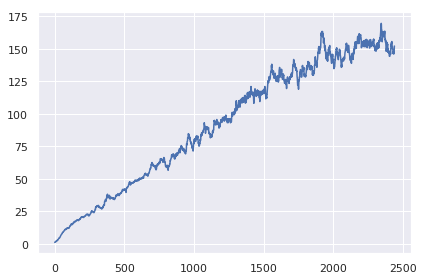

In [6]:
plt.plot(range(len(result)), result)
plt.tight_layout()
plt.show()

In [7]:
from matplotlib import animation

def display_frames_as_gif(frames):
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])
        
    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=5)
    anim.save('./cfh_breakout_result.gif', writer='imagemagick', fps=30)

/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Total Reward : 222.00


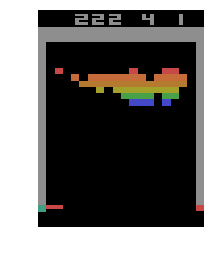

In [10]:
env = wrap(gym.make('BreakoutNoFrameskip-v4'))
s = np.array(env.reset())
total_reward = 0
done_counter = 0
frames = []

for t in range(10000):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    a, v, l = ppo.choose_action(np.expand_dims(s,axis=0))
    # take action and get next state
    s_, r, done, info = env.step(a)
    s_ = np.array(s_)
    total_reward += r
    if done:
        
        done_counter += 1
        if done_counter == 5:
            break
    s = s_
env.close()
print('Total Reward : %.2f'%total_reward)
display_frames_as_gif(frames)

![alt text](./cfh_breakout_result.gif "segment")